# Figure panels comparing MAE and R2 for multiple models

Model options for comparison:
- PLS (i.e., main figure)
- ElasticNet
- GradientBoosting
- KNN

Cross-validation:
- leave-one-out

In [1]:
import numpy as np
import pandas as pd
import colorcet as cc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import median_absolute_error, r2_score
from aging.behavior.age_models import MODEL_OPTIONS, generate_pipeline
from sklearn.model_selection import KFold, cross_val_predict, cross_validate
from aging.plotting import format_plots, figure, save_factory, PLOT_CONFIG, COLORMAPS

In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig-s3-models", tight_layout=False)

In [3]:
keep_syllables = np.loadtxt(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt",
    dtype=int,
)

def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')
    return df


def read_female_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    # re-assign 52-wk old animals from their incorrect 8-wk old assignment
    x = ['d6f254af-d55a-427a-96e0-c452a233cbe2', '242bee8e-0ee7-45e7-8a13-678836a4cddb']

    idx = df.index.names
    tmp_df = df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    df = tmp_df.set_index(idx)

    age_mapping = {
        93: 94,
        95: 94,
        97: 98,
        98: 98,
        102: 98,
        103: 105,
        105: 105,
        107: 105
    }

    df = df.reset_index(level='age')
    df['age'] = df['age'].map(age_mapping).fillna(df['age'])

    return df.set_index('age', append=True).reorder_levels(idx)


def fit_seq(mdl, X, y, mdl_type, sex, use_log):
    mae = median_absolute_error(y, y_pred)

    return mae, np.mean(r2s)

In [4]:
def fit_model(pipeline, X, y, n_repeats=3):

    r2s = []
    maes = []
    for i in tqdm(range(n_repeats)):
        y_pred = cross_val_predict(
            pipeline,
            X,
            y,
            cv=KFold(15, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        r2s.append(
            r2_score(
                y,
                y_pred,
            )
        )
        maes.append(median_absolute_error(y, y_pred))

    return r2s, maes


def fit_model2(pipeline, X, y, n_repeats=3, display=True):
    r2s = []
    maes = []
    for i in tqdm(range(n_repeats), display=display):
        cv = cross_validate(
            pipeline,
            X,
            y,
            scoring=["r2", "neg_median_absolute_error"],
            n_jobs=-1,
            cv=KFold(5, shuffle=True, random_state=i),
        )
        r2s.extend(cv["test_r2"])
        maes.extend(-cv["test_neg_median_absolute_error"])

    return r2s, maes

In [5]:
male_df = read_male_ontogeny(keep_syllables) + 1e-4
female_df = read_female_ontogeny(keep_syllables) + 1e-4
male_age = male_df.index.get_level_values('age')
female_age = female_df.index.get_level_values('age')

In [6]:
opts1 = pd.read_parquet('/n/scratch/users/w/wg41/2024-07-22-age-prediction-model-optimization.parquet')
opts2 = pd.read_parquet('/n/scratch/users/w/wg41/2024-07-22-age-prediction-model-optimization-2.parquet')

In [7]:
opts1.loc[opts1.groupby('model')['mae'].idxmin().values]

,model,mae,r2,sex,log_xform,poly_xform,max_depth,n_estimators,metric,n_neighbors,weights,n_components,activation,hidden_layer_sizes,max_fun,max_iter,solver
105,gb,7.545455,0.660281,m,True,False,6.0,500.0,None,NaN,None,NaN,None,None,NaN,NaN,None
128,knn,7.877015,0.700292,m,True,False,NaN,NaN,cosine,19.0,distance,NaN,None,None,NaN,NaN,None
28,mlp,8.039476,0.658907,m,False,False,NaN,NaN,None,NaN,None,NaN,tanh,[200],100000.0,10000.0,lbfgs
36,pls,8.419126,0.707785,m,True,False,NaN,NaN,None,NaN,None,6.0,None,None,NaN,NaN,None


In [8]:
opts2.loc[opts2.groupby('model')['mae'].idxmin().values]

,model,mae,r2,sex,log_xform,poly_xform,alpha,l1_ratio,max_iter,C,kernel
159,elastic,8.082457,0.717971,m,True,False,0.464159,0.55,5000.0,NaN,None
248,svm,7.705408,0.737166,m,True,False,NaN,NaN,NaN,25.118864,rbf


## Fit models

In [9]:
models = {
    'pls': MODEL_OPTIONS['pls'](n_components=6),
    'gb': MODEL_OPTIONS['gb'](max_depth=6, n_estimators=300),
    'knn': MODEL_OPTIONS['knn'](metric='cosine', n_neighbors=20, weights='distance'),
    'elastic': MODEL_OPTIONS['elastic'](alpha=0.45, l1_ratio=0.55, max_iter=5_000),
}

In [10]:
# outputs = []
outputs2 = []
for model_name, mdl in tqdm(models.items()):
    for sex in ("m", "f"):
        X = male_df if sex == "m" else female_df
        y = male_age if sex == "m" else female_age
        pipeline = generate_pipeline(mdl, use_poly=False, use_log=True)
        # r2s, maes = fit_model(pipeline, X, y, n_repeats=2)
        r2s2, maes2 = fit_model2(pipeline, X, y, n_repeats=25)
        # outputs.append(
        #     pd.DataFrame(
        #         dict(r2=r2s, mae=maes, model=model_name, sex=sex, type="observed")
        #     )
        # )
        outputs2.append(
            pd.DataFrame(
                dict(r2=r2s2, mae=maes2, model=model_name, sex=sex, type="observed")
            )
        )

# run shuffles
n_shuff = 25
np.random.seed(23)
# _outputs = []
_outputs2 = []
for model_name, mdl in tqdm(models.items()):
    for sex in ("m", "f"):
        X = male_df if sex == "m" else female_df
        y = male_age if sex == "m" else female_age
        pipeline = generate_pipeline(mdl, use_poly=False, use_log=True)
        for shuff in tqdm(range(n_shuff)):
            y = np.random.permutation(y)
            # r2s, maes = fit_model(pipeline, X, y, n_repeats=1, display=False)
            r2s2, maes2 = fit_model2(pipeline, X, y, n_repeats=1, display=False)
            # _outputs.append(
            #     dict(r2=r2s[0], mae=maes[0], model=model_name, sex=sex, type="shuffle")
            # )
            _outputs2.append(
                dict(r2=r2s2[0], mae=maes2[0], model=model_name, sex=sex, type="shuffle")
            )
# outputs = pd.concat(outputs + [pd.DataFrame(_outputs)])
outputs2 = pd.concat(outputs2 + [pd.DataFrame(_outputs2)])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

/tmp/ipykernel_2789/1822133185.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set(xticklabels=["E-net", "PLS", "Grad. boost", "K-NN"], xlabel="Model type")
/tmp/ipykernel_2789/1822133185.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set(xticklabels=["E-net", "PLS", "Grad. boost", "K-NN"], xlabel="Model type")
webf NOT subset; don't know how to subset; dropped


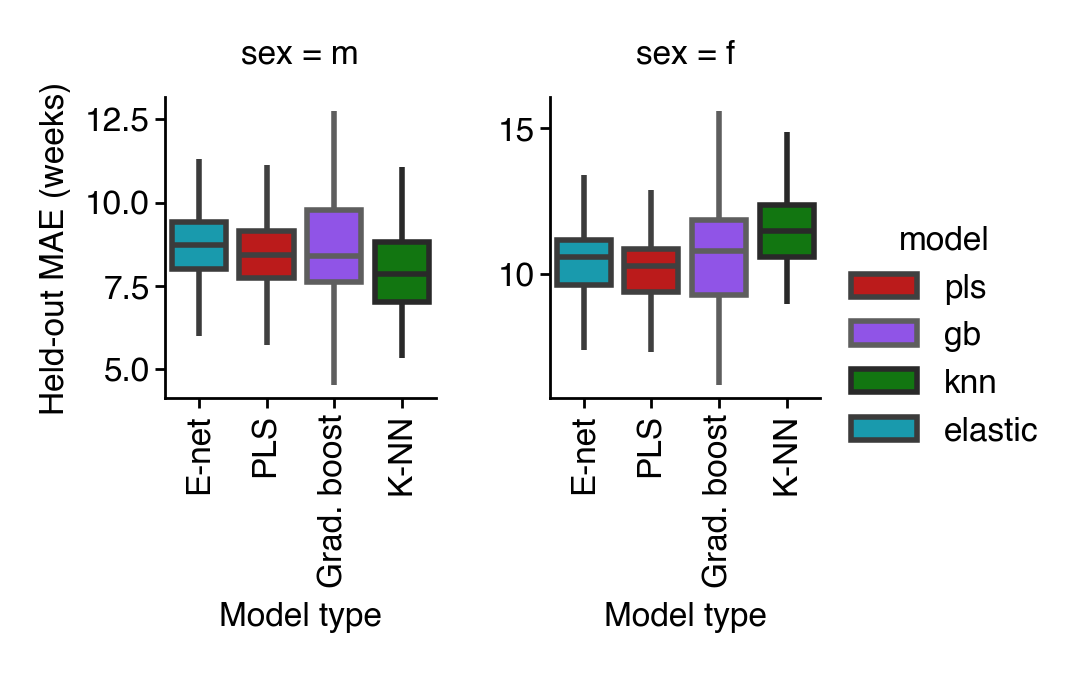

In [24]:
fgrid = sns.FacetGrid(
    data=outputs2.query('type == "observed"'),
    col="sex",
    height=1.3,
    aspect=0.8,
    hue="model",
    palette=cc.glasbey[:4],
    sharey=False,
)
fgrid.map(
    # sns.stripplot,
    sns.boxplot,
    "model",
    "mae",
    order=["elastic", "pls", "gb", "knn"],
    showfliers=False,
    showcaps=False,
    # s=3,
    # linewidth=0,
    # jitter=0.2
)
for i, a in enumerate(fgrid.axes.flat):
    if i == 0:
        a.set(ylabel="Held-out MAE (weeks)")
    a.set(xticklabels=["E-net", "PLS", "Grad. boost", "K-NN"], xlabel="Model type")
    a.tick_params(axis='x', rotation=90)
fgrid.add_legend()
saver(fgrid.fig, "age-mae-across-models");

In [ ]:
fgrid = sns.FacetGrid(
    data=outputs2,
    col="sex",
    height=1.3,
    aspect=0.8,
    hue="type",
    hue_order=['shuffle', "observed"],
    palette=['#ddd', "#777"],
    sharey=False,
)
fgrid.map(
    # sns.stripplot,
    sns.boxplot,
    "model",
    "r2",
    order=["elastic", "pls", "gb", "knn"],
    showfliers=False,
    showcaps=False,
    # s=2.5,
    # linewidth=0,
    # jitter=0.2
)
for i, a in enumerate(fgrid.axes.flat):
    if i == 0:
        a.set(ylabel="Held-out R2")
    a.set(xticklabels=["E-net", "PLS", "Grad. boost", "K-NN"], xlabel="Model type")
    a.tick_params(axis='x', rotation=90)
fgrid.add_legend()
saver(fgrid.fig, "age-r2-across-models");

/tmp/ipykernel_2789/879220891.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set(xticklabels=["E-net", "PLS", "Grad. boost", "K-NN"], xlabel="Model type")
/tmp/ipykernel_2789/879220891.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set(xticklabels=["E-net", "PLS", "Grad. boost", "K-NN"], xlabel="Model type")
